# ADM Homework 4 - group 4 

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import hashlib
import random
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from kneed import KneeLocator

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
File_Path = '/content/drive/MyDrive/Colab Notebooks/ADM - DataScience/ADM-4/vodclickstream_uk_movies_03.csv'
df = pd.read_csv(File_Path)

# 1.Recommendation system

## Preprocessing


The genres column has some rows with "NOT AVAILABLE" in it, we will remove those.

In [25]:
df = df[(df['release_date'] != 'NOT AVAILABLE') & (df['genres'] != 'NOT AVAILABLE')]
df.reset_index(drop=True, inplace=True)

In [26]:
# Remove leading and trailing spaces from the genres column
df['genres'] = df['genres'].str.strip()

## 1.1.

Searching the dataset to find each unique user, and run the movies_watched_by_user function to find all the movies watched by each user.

In [7]:
def movies_watched_by_user(user_id, df):
    user_movies = df[df['user_id'] == user_id]
    movies_count = user_movies['title'].value_counts().reset_index()
    movies_count.columns = ['title', 'count']
    return movies_count

In [27]:
users = df['user_id'].unique()

first_Ten = np.random.choice(users, 10) # Let's only print 10 users
for user in first_Ten:
    clicked_movies = movies_watched_by_user(user, df).head(10)
    print(f"User : {user}\n{clicked_movies}")

User : 6faad8a551
                     title  count
0          War on Everyone      4
1                 Deadpool      2
2  What Happened to Monday      1
3                  Gun Shy      1
User : c02a8591f4
                        title  count
0  Black Mirror: Bandersnatch      2
1                 Escape Room      1
User : 0ea15e0b1d
          title  count
0  Annihilation      1
1        BLAME!      1
User : 6a4b980687
                     title  count
0  The Fate of the Furious      3
1      The Young Offenders      2
2           Murder Mystery      1
User : ea53359404
                title  count
0  The Princess Bride      1
User : 7e71cbc80a
                   title  count
0          Born to Dance      1
1  It's a Boy Girl Thing      1
2             Blind Date      1
User : e810dba37a
          title  count
0  Batman Ninja      1
User : ab9012f872
      title  count
0  Hot Fuzz      1
User : d5fdf853cd
         title  count
0  Grown Ups 2      2
1    Grown Ups      1
User : 63e522d02

## 1.2 - 1.3. Minhash Signatures & Locality-Sensitive Hashing (LSH)

Aggregating the genres for each users. The reason we are keeping duplicates is that, if we do not than after a certain time each user will have all the genres in this list as they start to click more and more movies. This helps us to keep hte jaccard similarity scores from becoming 1.0 with a lot of other users. Another implementation could have been creating a dictionary of all 39 genres and keeping count of the genres of each movie clicked. But for the context of our assignment we made the dicision to go with this approach to keep the calculations for the MinHash and lsh simple.

In [29]:
# Convert 'genres' column to a list
df['genres'] = df['genres'].apply(lambda x: x.split(', '))
user_genres = {}

# Iterate over each group (user) and aggregate genres with tqdm
for user_id, group in tqdm(df.groupby('user_id'), desc="Aggregating Genres for each User"):
    genres = []
    for _, row in group.iterrows():
        genres.extend(row['genres'])
    user_genres[user_id] = genres
unique_users_df = pd.DataFrame(list(user_genres.items()), columns=['unique_user_id', 'agg_genres'])
print(unique_users_df.head(10))

Aggregating Genres for each User: 100%|██████████| 157622/157622 [01:13<00:00, 2151.06it/s]


  unique_user_id                                         agg_genres
0     00004e2862                           [Crime, Drama, Thriller]
1     000052a0a0  [Crime, Drama, Thriller, Crime, Drama, Thrille...
2     000090e7c8                        [Mystery, Sci-Fi, Thriller]
3     000118a755                                           [Horror]
4     000296842d  [Drama, Mystery, Sci-Fi, Thriller, Drama, Myst...
5     0002aab109  [Comedy, Crime, Drama, Biography, Drama, Biogr...
6     0002abf14f   [Drama, Romance, Drama, Romance, Drama, Romance]
7     0002d1c4b1                                   [Comedy, Sci-Fi]
8     000499c2b6    [Animation, Adventure, Comedy, Family, Fantasy]
9     00051f0e1f                [Action, Adventure, Comedy, Sci-Fi]


Creating the functions to create the MinHash signatures of each user. This MinHash signature is than used to pool similar users into the same buckets using LSH. Once all the users are pooled into buckets, The Jaccard similarity function (A ∩ B / A ∪ B) is to find the most similarity precisely.

In [30]:
class MinHash:
    def __init__(self, num_perm):
        self.num_perm = num_perm
        self.hash_values = [float('inf')] * num_perm

    def update(self, value):
        for i in range(self.num_perm):
            # Use a hash function
            hash_val = int(hashlib.sha256(f"{value}_{i}".encode('utf-8')).hexdigest(), 16)
            self.hash_values[i] = min(self.hash_values[i], hash_val)
def jaccard_similarity(minhash1, minhash2):
    common_count = sum(x == y for x, y in zip(minhash1.hash_values, minhash2.hash_values))
    union_size = len(minhash1.hash_values) + len(minhash2.hash_values) - common_count
    return common_count / union_size

In [31]:
class LSH:
    def __init__(self, num_perm, bands, rows):
        self.num_perm = num_perm
        self.bands = bands
        self.rows = rows
        self.hash_tables = [{} for _ in range(bands)]

    def insert(self, user_id, minhash):
        for i in range(self.bands):
            band_hash = hash(tuple(minhash.hash_values[i * self.rows : (i + 1) * self.rows]))
            if band_hash not in self.hash_tables[i]:
                self.hash_tables[i][band_hash] = []
            self.hash_tables[i][band_hash].append(user_id)

    def query(self, minhash):
        candidate_set = set()
        for i in range(self.bands):
            band_hash = hash(tuple(minhash.hash_values[i * self.rows : (i + 1) * self.rows]))
            if band_hash in self.hash_tables[i]:
                candidate_set.update(self.hash_tables[i][band_hash])
        return candidate_set

In [32]:
# Creating LSH index
num_perm = 128
bands = 8
rows = num_perm // bands
lsh_index = LSH(num_perm=num_perm, bands=bands, rows=rows)

user_minhashes = {} # Useful to store MinHash signatures for each user

# Create MinHash signatures for users and insert into LSH index
for index, row in tqdm(unique_users_df.iterrows(), total=len(unique_users_df), desc="Creating MinHash Signatures"):
    user_id = row['unique_user_id']
    genres = row['agg_genres']

    minhash = MinHash(num_perm=num_perm)
    for genre in genres:
        minhash.update(genre)

    lsh_index.insert(user_id, minhash)
    user_minhashes[user_id] = minhash

Creating MinHash Signatures: 100%|██████████| 157622/157622 [11:08<00:00, 235.71it/s]


In [71]:
# Query
query_user_id = "000052a0a0"
query_minhash = MinHash(num_perm=num_perm)
query_genres = unique_users_df[unique_users_df['unique_user_id'] == query_user_id]['agg_genres'].iloc[0]


for genre in query_genres:
    query_minhash.update(genre)

In [72]:
# Query LSH index for similar users
similar_user_ids = lsh_index.query(query_minhash)

# Calculate Jaccard similarity for potential similar users and store the results
similar_users = []
for similar_user_id in similar_user_ids:
    if similar_user_id != query_user_id:  # Ignore the query user
        similar_user_minhash = user_minhashes[similar_user_id]

        # Calculate Jaccard similarity or use the MinHash similarity directly
        jaccard_similarity_score = jaccard_similarity(query_minhash, similar_user_minhash)

        similar_users.append({"user_id": similar_user_id, "similarity": jaccard_similarity_score})

# Sort similar users by Jaccard similarity in descending order
similar_users.sort(key=lambda x: x["similarity"], reverse=True)

top_two_similar_users = [(user["user_id"], user["similarity"]) for user in similar_users[:2]] # Take the top 2

print(f"The two most similar users to {query_user_id} are: {top_two_similar_users}")


The two most similar users to 000052a0a0 are: [('2bc1cc7445', 0.9104477611940298), ('67b5dc6e38', 0.9104477611940298)]


Since we only have 'few' data to work with, the jaccard similarity scores are very high. If our dataset included information about more movies for each individual user, the jaccard similarity scores would start to get lower, and we will not have this problem of having multiple users with 1.0 scores. The main issue here is that each user have very few 'movie clicks' and these movies have similar genres. This combined with the fact that there are only 39 different genres equal to this problem. Once we have data about more movie clicks for each user,the agg_genres will start to vary significantly from user to user(since we are keeping duplicates of genres in the list) giving us a better picture of which users are actually more similar!

In [73]:
# Test to check if there are some Jaccard similarity != 1 from other users
print(similar_user_ids)
test = 0
for user in similar_user_ids:
    test += 1
    manual_jaccard_similarity = jaccard_similarity(query_minhash, user_minhashes[user])
    print(f"User: {user}  Jaccard Similarity: {manual_jaccard_similarity}")
    if (test==5):
      break


{'1b49ce4c68', 'dafa2c64cb', '2bc1cc7445', 'ffe3133880', 'd855866483', '3c3d8ecc9a', '838bccaec6', '7576e9a6d2', 'ae2d63e302', 'e68fc46005', 'e626d644d8', '2d9347fc58', '117605fa60', '0ac85da99d', '000052a0a0', '18ec742a2c', 'bc0ea7b235', '979b1b64b8', 'c2e9bc5997', 'eaf069a3ae', 'dc7d24b54f', '6d8410f691', '1ec1abc2c5', 'f2d90a57cc', '6ab36797ea', 'd574b20ea9', 'e741bf79e9', 'cdce991194', '48ee8fa7e8', 'f9ce7b8bb8', '1b610a75ac', '19c41070cf', '0f9eac7f32', '525e3bef8d', '9e3c09142d', '6fb9bf0df4', '666f340f6f', 'c83546624f', '100c95b4e1', 'c0cd5b6801', 'af3c246e30', '6718ae9e57', 'ff7183a6da', '590881cc13', 'c5cdeebc68', '38480a19cd', 'fe4c122daf', 'd3995120c4', 'f2db2a25da', '92d8104e15', 'd1e5ffc888', 'd64055e54f', '665a1e2316', 'f571b82abe', 'bac2d604dd', '67b5dc6e38', 'd347fc5273', 'a607c643b4', 'f9ab08f0af', '3bc3e5bab3', 'f35babd544', 'e7f412c820', 'f17441184d', '955dd5a963', 'd42f279d9a', '839a082f67', '6efe3948b9', 'bfa48a0a9c', '8831e163e3', 'edab7a41b7', '2844826182', '8715

In [74]:
# Test to check if the different users have similar genres in common
test = 0
for user_id in similar_user_ids:
    test += 1
    print(f"User ID: {user_id}, Genres: {user_genres[user_id]}")
    if (test==5):
      break

User ID: 1b49ce4c68, Genres: ['Action', 'Adventure', 'Drama', 'Sci-Fi', 'Thriller', 'Comedy', 'Sport', 'Adventure', 'Comedy', 'Family', 'Fantasy', 'Horror', 'Comedy', 'Crime', 'Comedy', 'Mystery', 'Thriller', 'Comedy', 'Mystery', 'Thriller']
User ID: dafa2c64cb, Genres: ['Comedy', 'Drama', 'Family', 'Fantasy', 'Action', 'Comedy', 'Crime', 'Thriller', 'Animation', 'Action', 'Adventure', 'Comedy', 'Family', 'Fantasy', 'Sci-Fi', 'Action', 'Adventure', 'Comedy', 'Crime', 'Thriller', 'Animation', 'Adventure', 'Comedy', 'Family', 'Fantasy', 'Horror', 'Mystery', 'Sci-Fi', 'Animation', 'Adventure', 'Comedy', 'Family', 'Music']
User ID: 2bc1cc7445, Genres: ['Animation', 'Adventure', 'Comedy', 'Family', 'Fantasy', 'Animation', 'Action', 'Drama', 'Fantasy', 'Horror', 'Sci-Fi', 'Thriller', 'Horror', 'Mystery', 'Thriller', 'Animation', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Family', 'Comedy', 'Family', 'Fantasy', 'Drama', 'Adventure', 'Family', 'Sport', 'Animation', 'Adventure', 'Comedy', 'Famil

In [78]:
# Function to find all the movies watched by the user
def movies_watched_by_user(user_id, df):
    user_movies = df[df['user_id'] == user_id]
    movies_count = user_movies['title'].value_counts().reset_index()
    movies_count.columns = ['title', 'count']
    return movies_count

In [76]:
# Extract similar user_ids
top_similar_users = [user_id for user_id, _ in top_two_similar_users]
user_movies = {}

for user_id in top_similar_users: # Get movies watched by each top similar user
    movies_watched = movies_watched_by_user(user_id, df)
    user_movies[user_id] = movies_watched
    print(f"\nUser ID: {user_id}\nMovies clicked: {movies_watched}")


User ID: 2bc1cc7445
Movies clicked:                    title  count
0             Fight Club      2
1       Arthur Christmas      1
2                GANTZ:O      1
3                 Hostel      1
4      Fantastic Mr. Fox      1
5                Matilda      1
6     The Black Stallion      1
7                Minions      1
8               Rain Man      1
9   Hotel Transylvania 2      1
10    Hotel Transylvania      1

User ID: 67b5dc6e38
Movies clicked:                                              title  count
0                            Live Free or Die Hard      3
1                                         Blow Out      2
2                      Goon: Last of the Enforcers      2
3            The Girl Who Kicked the Hornets' Nest      1
4                       Ace Ventura: Pet Detective      1
5                                           2 Guns      1
6                                       Waterworld      1
7   Wallace & Gromit: The Curse of the Were-Rabbit      1
8                   

Using the recommendation set in the RQ to create the suggestion list.

In [77]:
# Check if there are common movies
common_movies = pd.concat([user_movies[user_id].set_index('title') for user_id in top_similar_users], axis=1, join='inner')

#Sort common movies by the sum of counts across both users in descending order
sorted_common_movies = common_movies.sum(axis=1).sort_values(ascending=False)

# Separate common movies from individual movies
common_movies_list = sorted_common_movies.index.tolist()
individual_movies = [user_movies[user_id].sort_values(by='count', ascending=False).reset_index() for user_id in top_similar_users]
individual_movies = [df[~df['title'].isin(common_movies_list)] for df in individual_movies]

recommendation_list = common_movies_list[:5]

# Check if we need more movies from individual users
remaining_slots = 5 - len(recommendation_list)

# Fill the recommendation list with movies from user 1
recommendation_list += individual_movies[0]['title'].head(remaining_slots).tolist()
remaining_slots = 5 - len(recommendation_list)

# If needed, fill the remaining slots with movies from user 2
if remaining_slots > 0:
    recommendation_list += individual_movies[1]['title'].head(remaining_slots).tolist()

print("\nRecommended movies in order:")
for title in recommendation_list:
    counts = [user_movies[user_id].set_index('title').loc[title, 'count'] if title in user_movies[user_id]['title'].values else 0 for user_id in top_similar_users]
    print(f"Title: {title}, Counts: {counts}")


Recommended movies in order:
Title: Fight Club, Counts: [2, 0]
Title: Arthur Christmas, Counts: [1, 0]
Title: GANTZ:O, Counts: [1, 0]
Title: Hostel, Counts: [1, 0]
Title: Fantastic Mr. Fox, Counts: [1, 0]


Since there are no common movies between the two users similar to the query, the first user gets priority. Since he watched 5 movies, those 5 movies are recommended for the query user

# 2.Grouping Users together!

## Preprocessing
Removing negative values from the duration column.

In [79]:
# Filter out rows with negative durations
df = df[df['duration'] >= 0]

## 2.1. Getting your data + feature engineering

### 2.1.2.

#### 2.1.a.


First we separate all the different genres of each movie, group the together by duration and index the maximum value to get the favorite genres of each user ID.

In [ ]:
# Split the 'genres' column into separate genres
df['fav_genre'] = df['genres'].str.split(', ')

df_exploded = df.explode('fav_genre')
grouped_data = df_exploded.groupby(['user_id', 'fav_genre'])['duration'].sum().reset_index() # Grouping by user and genre, then sum the durations

# Genre with highest duration for each user
idx = grouped_data.groupby('user_id')['duration'].idxmax()
result = grouped_data.loc[idx]

new_df = result[['user_id', 'fav_genre']]

#### 2.1.b.
Average user click duration.

In [ ]:
# Calculating average click duration for each user
avg_click_duration = df.groupby('user_id')['duration'].mean().reset_index()
new_df = pd.merge(new_df, avg_click_duration)
new_df = new_df.rename(columns={'duration': 'avg_click_duration'})

#### 2.1.c.

First we convert the datetime column to Pandas datetime format, we use the formatted time to calculate each movie clicks time period of the day, and finally we find the max value for the favorite time of the day for each user.

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['time_of_day'] = pd.cut(df['datetime'].dt.hour, bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Night'], ordered=False) # Bins = intervals to find the different times of the day

# Find the time of the day with the maximum duration for each user
time_of_day_max_duration = df.groupby(['user_id', 'time_of_day'])['duration'].sum().reset_index()
idx_time_of_day = time_of_day_max_duration.groupby('user_id')['duration'].idxmax()
result_time_of_day = time_of_day_max_duration.loc[idx_time_of_day]
new_df = pd.merge(new_df, result_time_of_day[['user_id', 'time_of_day']])

#### 2.1.d.


Some release date rows are "NOT AVAILABLE". We decided to ignore those rows instead of removing them all together since those rows contain valueable information on the other columns.

In [ ]:
# Convert the column ignoring errors
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Determin if the user prefers old or recent content
df['release_year'] = df['release_date'].dt.year
old_movie_lover = df[df['release_year'] < 2010].groupby('user_id').size().reset_index(name='old_movie_count')
recent_movie_lover = df[df['release_year'] >= 2010].groupby('user_id').size().reset_index(name='recent_movie_count')
movie_preference = pd.merge(old_movie_lover, recent_movie_lover, on='user_id', how='outer').fillna(0)
movie_preference['preference'] = 'Old'  # Default preference is set to 'Old'
movie_preference.loc[movie_preference['recent_movie_count'] > movie_preference['old_movie_count'], 'preference'] = 'Recent'
new_df = pd.merge(new_df, movie_preference[['user_id', 'preference']])

#### 2.1.e.
Calculation the daily average for each user ID.

In [ ]:
daily_avg_duration = df.groupby(['user_id', df['datetime'].dt.date])['duration'].sum().groupby('user_id').mean().reset_index(name='daily_avg_duration')
new_df = pd.merge(new_df, daily_avg_duration)

#### Visualizing our new dataframe.

In [ ]:
new_df.sample(5)

,user_id,fav_genre,avg_click_duration,time_of_day,preference,daily_avg_duration
55190,5e05493ef1,Documentary,10174.0,Afternoon,Recent,20348.000000
144846,f64ea85165,Adventure,294008.8,Afternoon,Old,490014.666667
106193,b4a2d77b8b,Biography,0.0,Afternoon,Recent,0.000000
33477,39090518b6,Action,1220.0,Night,Recent,1220.000000
13263,16baf593e4,Comedy,0.0,Afternoon,Old,0.000000


### 2.1.3. reating 10 new features for our dataset.


#### Feature 1: Total duration spent on the platform by each user

In [ ]:
total_duration_per_user = df.groupby('user_id')['duration'].sum()
new_df['total_duration'] = new_df['user_id'].map(total_duration_per_user)

#### Feature 2: Number of distinct genres the user has clicked on

In [ ]:
distinct_genres_per_user = df.groupby('user_id')['fav_genre'].agg(lambda x: len(set(y for sublist in x for y in sublist)))
new_df['num_distinct_genres'] = new_df['user_id'].map(distinct_genres_per_user)

#### Feature 3: Total duration of clicks in the user's favorite genre

In [ ]:
# Explode the 'genres' column into separate rows
df_exploded_genres = df.explode('genres')

# Calculate the total duration of clicks in the user's favorite genre
fav_genre_total_duration = df_exploded_genres[df_exploded_genres['genres'].isin(new_df['fav_genre'])].groupby('user_id')['duration'].sum()
fav_genre_total_duration = fav_genre_total_duration.reset_index(name='fav_genre_duration').fillna(0)
new_df = pd.merge(new_df, fav_genre_total_duration)

#### Feature 4: Number of clicks on weekends

In [ ]:
df['is_weekend'] = (df['datetime'].dt.weekday >= 5).astype(int)
total_weekend_clicks = df.groupby('user_id')['is_weekend'].sum().reset_index(name = 'total_weekend_clicks')
new_df = pd.merge(new_df, total_weekend_clicks)

#### Feature 5: Click frequency per day

In [ ]:
clicks_per_day = df.groupby(['user_id', pd.to_datetime(df['datetime']).dt.date])['datetime'].count().reset_index(name='clicks_per_day')
avg_clicks_per_day = clicks_per_day.groupby('user_id')['clicks_per_day'].mean()
new_df['avg_clicks_per_day'] = new_df['user_id'].map(avg_clicks_per_day).fillna(0)

#### Feature 6: Number of clicks per user

In [ ]:
num_clicks_per_user = df['user_id'].value_counts()
new_df['num_clicks'] = new_df['user_id'].map(num_clicks_per_user)

#### Feature 7: Calculate the average number of clicks per day for each user

In [ ]:
avg_clicks_per_day = df.groupby(['user_id', df['datetime'].dt.date]).size().groupby('user_id').mean().reset_index(name='avg_clicks_per_day')
new_df = pd.merge(new_df, avg_clicks_per_day)

#### Feature 8: Number of clicks on old movies

In [ ]:
new_df['is_old_movie_lover'] = (pd.to_datetime(df['release_date']).dt.year < 2010).astype(int)

#### Feature 9: Percentage of movies watched that are considered old (released before 2010)


In [ ]:
old_movies_percentage = df[df['release_year'] < 2010].groupby('user_id').size() / df.groupby('user_id').size()
new_df['old_movies_percentage'] = old_movies_percentage.reset_index(name='old_movies')['old_movies'].fillna(0)

#### Feature 10: Maximum duration of a single click for each user

In [ ]:
new_df['max_click_duration'] = df.groupby('user_id')['duration'].max().reset_index()['duration']

#### Visualizing our new Dataframe

In [ ]:
new_df.sample(5)

,user_id,fav_genre,avg_click_duration,time_of_day,preference,daily_avg_duration,total_duration,num_distinct_genres,fav_genre_duration,total_weekend_clicks,avg_clicks_per_day,num_clicks,is_old_movie_lover,old_movies_percentage,max_click_duration
34339,b54f856464,Family,0.000000,Afternoon,Recent,0.000000,0.0,1,0.0,0,1.000000,1,0.0,0.2,600.0
987,0532fd265d,Adventure,7867.515152,Afternoon,Recent,19971.384615,259628.0,16,0.0,17,2.538462,33,1.0,1.0,7937.0
491,0274c96571,Documentary,0.000000,Afternoon,Old,0.000000,0.0,1,0.0,0,1.000000,1,0.0,0.0,0.0
14539,4d48753987,Action,119.800000,Night,Recent,299.500000,599.0,9,0.0,2,2.500000,5,1.0,0.4,3880.0
35220,ba1212ef20,Comedy,42815.250000,Night,Recent,42815.250000,171261.0,6,171261.0,3,1.000000,4,1.0,0.0,6384.0


## 2.2. Choose your features (variables)!

Normalization (or scaling) is a technique used to standardize the range of independent variables or features of the data. Normalization can be beneficial in:

1. Distance-Based Algorithms: Normalizing features ensures that all features contribute equally to the distance calculations.
2. Gradient Descent Optimization:
3. Regularization Techniques
4. PCA (Principal Component Analysis): Normalization is essential because it is based on the variance of features.


**PCA** - [link_to_the_site]('https://stats.stackexchange.com/questions/69157/why-do-we-need-to-normalize-data-before-principal-component-analysis-pca')


However, there are situations where normalization might not be necessary or could even be detrimental:
1. Tree-Based Models
2. Interpretability

### 2.2.1 Normalizing the columns of new_df and creating a new dataframe called normalized_df

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Features to normalize
features_to_normalize = ['avg_click_duration', 'daily_avg_duration', 'total_duration', 'num_distinct_genres', 'fav_genre_duration', 'total_weekend_clicks', 'avg_clicks_per_day', 'num_clicks', 'max_click_duration']
normalized_df = new_df.copy()
scaler = MinMaxScaler()

# Fit and trasform the selected features in the normalized_df
normalized_df[features_to_normalize] = scaler.fit_transform(normalized_df[features_to_normalize])

normalized_df.sample(5)

,user_id,fav_genre,avg_click_duration,time_of_day,preference,daily_avg_duration,total_duration,num_distinct_genres,fav_genre_duration,total_weekend_clicks,avg_clicks_per_day,num_clicks,is_old_movie_lover,old_movies_percentage,max_click_duration
26331,8afcc433c0,Drama,0.001145,Night,Recent,0.001799,0.006817,0.409091,0.007033,0.000000,0.026786,0.013587,1.0,0.5,0.003478
26247,8a8f56cab8,Comedy,0.002614,Afternoon,Recent,0.004792,0.046699,0.772727,0.001622,0.021605,0.039062,0.043478,0.0,0.0,0.000000
2999,105856cf55,Documentary,0.000890,Night,Recent,0.002374,0.007713,0.454545,0.011106,0.015432,0.078125,0.020380,1.0,0.0,0.027962
29255,9a627ede04,Documentary,0.000000,Afternoon,Recent,0.000000,0.000000,0.000000,0.000000,0.003086,0.000000,0.001359,0.0,1.0,0.000000
42744,e14d9b2a4b,Drama,0.004765,Afternoon,Old,0.007147,0.007740,0.272727,0.006399,0.000000,0.023438,0.002717,1.0,1.0,0.006620


### 2.2.2 PCA

Explanation:
I chose PCA because it is a widely used method for dimensionality reduction, and it's suitable for continuous numerical features. It helps in capturing the most significant patterns of variance in the data and reducing the dimensionality while retaining as much information as possible.

Limitations:

Linearity: PCA assumes that the data is linear, and it might not perform well if the relationships between variables are non-linear.
Orthogonality: PCA creates orthogonal principal components, which may not always capture complex patterns present in the data.
Sensitive to Outliers: PCA is sensitive to outliers as it maximizes the variance, and outliers can have a significant impact on the results.
It's essential to consider the nature of your data and the assumptions of the method when choosing dimensionality reduction techniques. Additionally, you may want to explore other methods like t-SNE or UMAP for non-linear data or when preserving local structures is important.

In [ ]:
features_for_pca = ['avg_click_duration', 'daily_avg_duration', 'total_duration', 'num_distinct_genres', 'fav_genre_duration', 'total_weekend_clicks', 'avg_clicks_per_day', 'num_clicks', 'max_click_duration']
pca_features = normalized_df[features_for_pca]

# Instantiate PCA with the number of components (we choose 2 for illustration)
n_components = 8
pca = PCA(n_components=n_components)

# Fit and transform the features
pca_result = pca.fit_transform(pca_features)
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(n_components)])
pca_df['user_id'] = normalized_df['user_id']

pca_df.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,user_id
0,-0.204513,0.003104,-0.008607,-0.005976,0.003559,-0.000172,-0.001625,0.002791,000118a755
1,0.338869,-0.049106,-0.020668,-0.005562,-0.004402,0.008107,0.007673,-0.003288,0006ea6b5c
2,-0.251453,-0.016564,-0.008341,-0.005834,0.008370,0.002035,-0.000231,0.000256,0007fc8621
3,-0.156889,0.023206,-0.001786,-0.005893,0.007896,0.001394,0.002794,-0.004816,000a3ec774
4,0.022997,-0.003052,-0.006070,-0.002716,-0.004437,-0.006165,-0.000781,0.004768,000b3fbc4e


#### Scree plot of our normalized dataframe.

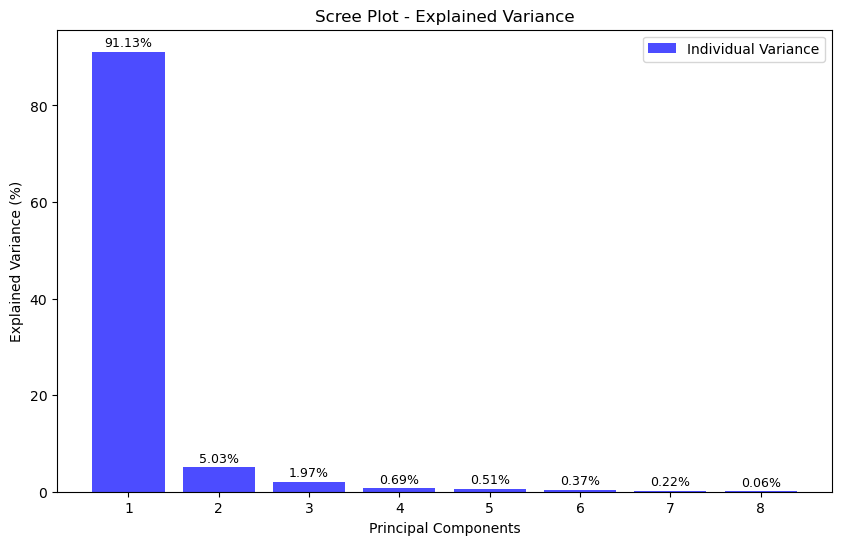

In [ ]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_) # cumulative explained variance
plt.figure(figsize=(10, 6))

plt.bar(range(1, n_components + 1), pca.explained_variance_ratio_ * 100, color='b', alpha=0.7, align='center', label='Individual Variance') # Individual explained variance

for i, percentage in enumerate(pca.explained_variance_ratio_ * 100):
    plt.text(i + 1, percentage + 0.5, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=9)

plt.title('Scree Plot - Explained Variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance (%)')
plt.legend()
plt.show()

From the above Scree plot, we can see that PC1 & PC2 account for 96.16% of the total variation of the dataset. Hence, for clustering we can use these three Principal components to cluster or data.

C:\Users\Syed Habibul Bashar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Syed Habibul Bashar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Syed Habibul Bashar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Syed Habibul Bashar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init

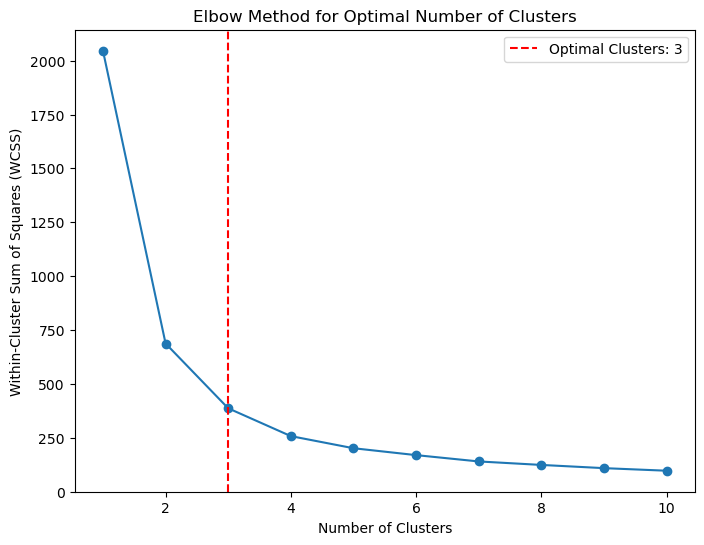

In [ ]:
# Extract PC1 and PC2
pc_columns = ['PC1', 'PC2']
pc_data = pca_df[pc_columns]

# Deciding the range of clusters
num_clusters_range = range(1, 11)

wcss = [] # Within-cluster sum of squares
for num_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(pc_data)
    wcss.append(kmeans.inertia_)

# Find the elbow point using KneeLocator
knee_locator = KneeLocator(num_clusters_range, wcss, curve='convex', direction='decreasing')
optimal_cluster_size = knee_locator.elbow

# Plot the elbow plot with highlighted optimum cluster size
plt.figure(figsize=(8, 6))
plt.plot(num_clusters_range, wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')

# Highlight the optimum cluster size
plt.axvline(x=optimal_cluster_size, color='red', linestyle='--', label=f'Optimal Clusters: {optimal_cluster_size}')
plt.legend()

plt.show()

## 2.3 Clustering!


To implement the kmeans algorithm we will be using the reduced dimensional values PCA1 & PCA2. Firstly, we initialize the centroids randomly. The centroids are then assigned clusters based on the distance of the data points respective of the centroids. With each iteration of kmeans we update the centroid to become more centralized meaning to reduce the means distances from the centroid to the data points until it can't be reduced anymore.

In [ ]:
data = pca_df[['PC1', 'PC2']].values.astype(float)

def initialize_centroids(data, k):
    indices = np.random.choice(len(data), k, replace=False)
    return data[indices]

def assign_clusters(data, centroids):
    distances = np.linalg.norm(data[:, np.newaxis, :] - centroids, axis=2)
    return np.argmin(distances, axis=1)

def update_centroids(data, clusters, k):
    centroids = np.zeros((k, data.shape[1]))
    for i in range(k):
        centroids[i] = np.mean(data[clusters == i], axis=0)
    return centroids

def kmeans(data, k, max_iters=100):
    centroids = initialize_centroids(data, k)

    for _ in range(max_iters):
        clusters = assign_clusters(data, centroids)
        new_centroids = update_centroids(data, clusters, k)

        # Check for convergence
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return clusters, centroids

def calculate_sse(data, clusters, centroids):
    sse = 0
    for i in range(len(centroids)):
        cluster_points = data[clusters == i]
        sse += np.sum((cluster_points - centroids[i])**2)
    return sse

Using the elbow method to find the optimal value of 'K'. The optimal value here is 3.

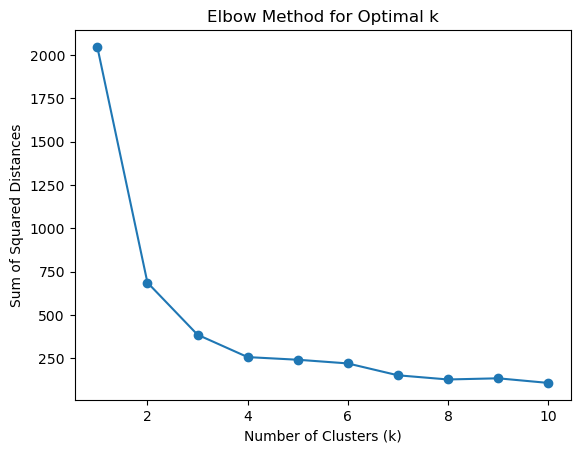

In [ ]:
# Function to determine optimal k using sum of squared distances
def find_optimal_k(data, max_k):
    sse_values = []
    for k in range(1, max_k + 1):
        clusters, centroids = kmeans(data, k)
        sse = calculate_sse(data, clusters, centroids)
        sse_values.append(sse)

    x = np.arange(1, max_k + 1)
    plt.plot(x, sse_values, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Sum of Squared Distances')
    plt.title('Elbow Method for Optimal k')
    plt.show()

max_k_value = 10
find_optimal_k(data, max_k_value)

Another method of find the optimal k is the silhouette method. Here the highest value of k is considered optimal. We can see 2 is the highest value, but it is too low, so the next best choice would be 5.

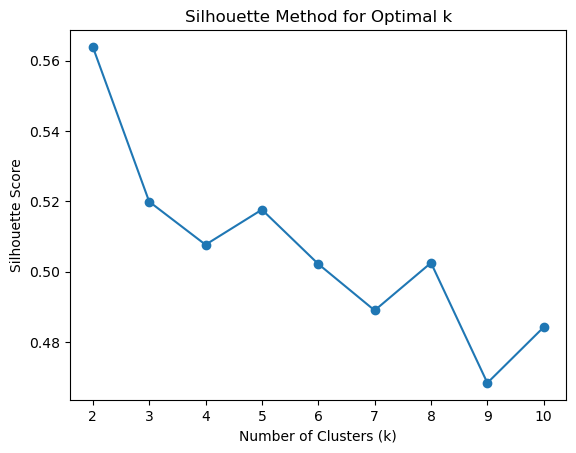

In [ ]:
def calculate_silhouette_score(data, clusters):
    return silhouette_score(data, clusters)

# Function to determine optimal k using silhouette score
def find_optimal_k_silhouette(data, max_k):
    silhouette_scores = []
    for k in range(2, max_k + 1):
        clusters, _ = kmeans(data, k)
        silhouette = calculate_silhouette_score(data, clusters)
        silhouette_scores.append(silhouette)

    x = np.arange(2, max_k + 1)
    plt.plot(x, silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method for Optimal k')
    plt.show()

max_k_value = 10
find_optimal_k_silhouette(data, max_k_value)

Visual representation of our data clusters using k=5.

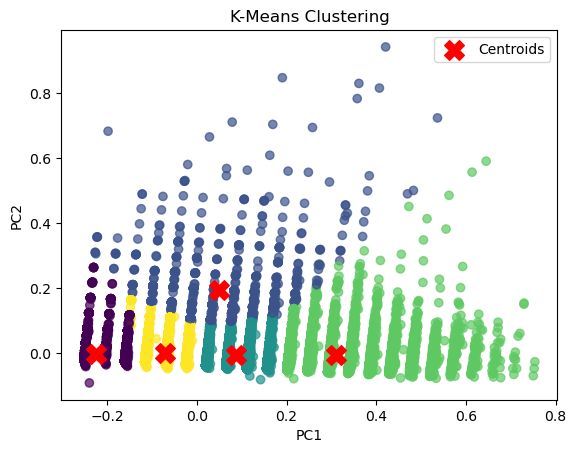

In [ ]:
# Function to plot the clustering result
def plot_clusters(data, clusters, centroids):
    plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', alpha=0.7)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
    plt.title('K-Means Clustering')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.show()
    # Example usage
k = 5
clusters, centroids = kmeans(data, k)
plot_clusters(data, clusters, centroids)

In the KMeans++ method, the first centroid is only initialized randomly,then rest of the centroids are spead out the dataset. This helps to get convergence faster. The main difference between standard and KMeans++ is execution time.

In [ ]:
def kmeans_plusplus_initialize(data, k):
    centroids = [data[np.random.choice(len(data))]]

    for _ in range(1, k):
        distances = np.min(np.linalg.norm(data[:, np.newaxis, :] - centroids, axis=2), axis=1)
        probabilities = distances / np.sum(distances)
        chosen_index = np.random.choice(len(data), p=probabilities)
        centroids.append(data[chosen_index])

    return np.array(centroids)



def kmeans_plus(data, k, max_iters=100):
    centroids = kmeans_plusplus_initialize(data, k)

    for _ in range(max_iters):
        clusters = assign_clusters(data, centroids)
        new_centroids = update_centroids(data, clusters, k)

        # Check for convergence
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return clusters, centroids


Elbow plot for the optimal k of KMeans++. here it is 3.

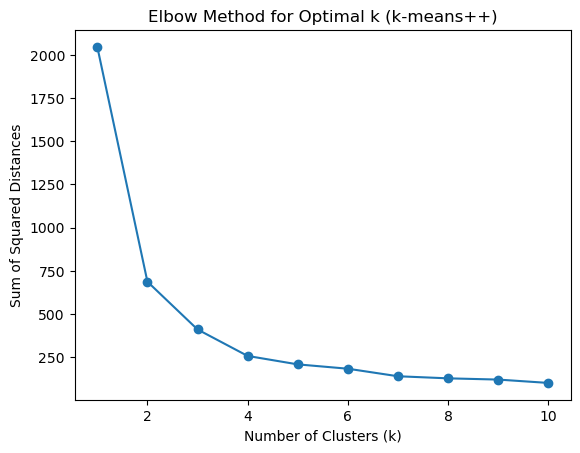

In [ ]:
#Elbow plus
# Function to determine optimal k using sum of squared distances
def find_optimal_k_plus(data, max_k):
    sse_values = []
    for k in range(1, max_k + 1):
        clusters, centroids = kmeans_plus(data, k)
        sse = calculate_sse(data, clusters, centroids)
        sse_values.append(sse)

    x = np.arange(1, max_k + 1)
    plt.plot(x, sse_values, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Sum of Squared Distances')
    plt.title('Elbow Method for Optimal k (k-means++)')
    plt.show()

# Example usage
max_k_value = 10
find_optimal_k_plus(data, max_k_value)

With KMeans++ the silhouette method suggests best k=2. Again it is too low for us. So we take a look a the next best k =5.

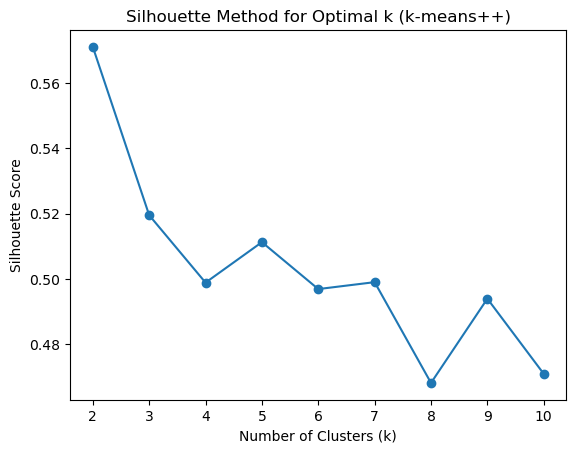

In [ ]:
# Function to determine optimal k using silhouette score
def find_optimal_k_silhouette_plus(data, max_k):
    silhouette_scores = []
    for k in range(2, max_k + 1):
        clusters, _ = kmeans_plus(data, k)
        silhouette = calculate_silhouette_score(data, clusters)
        silhouette_scores.append(silhouette)

    x = np.arange(2, max_k + 1)
    plt.plot(x, silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method for Optimal k (k-means++)')
    plt.show()

max_k_value = 10
find_optimal_k_silhouette_plus(data, max_k_value)

Trying k=3 and visualizing the results. (for comparison)

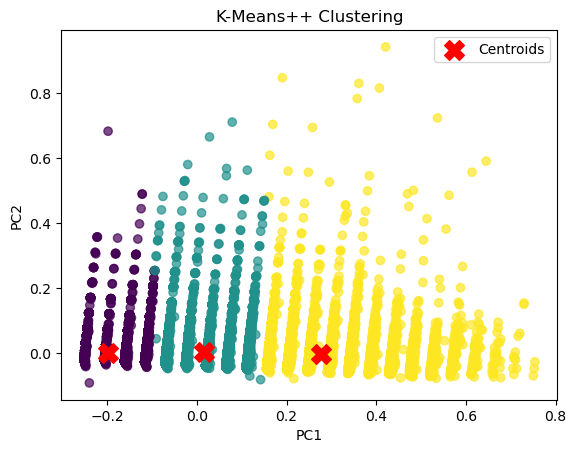

In [ ]:
# Function to plot the clustering result
def plot_clusters(data, clusters, centroids):
    plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', alpha=0.7)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
    plt.title('K-Means++ Clustering')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.show()
    # Example usage
k = 3
clusters, centroids = kmeans_plus(data, k)
plot_clusters(data, clusters, centroids)

Asked ChatGPT to implement a different clustering algorithm to our dataset. it chose DBSCAN. Here the clustering mainly consists of all the centalized data in a clustera dn the outliers in a different cluster. it goes in line with the silhouette methods recommendation of k=2.

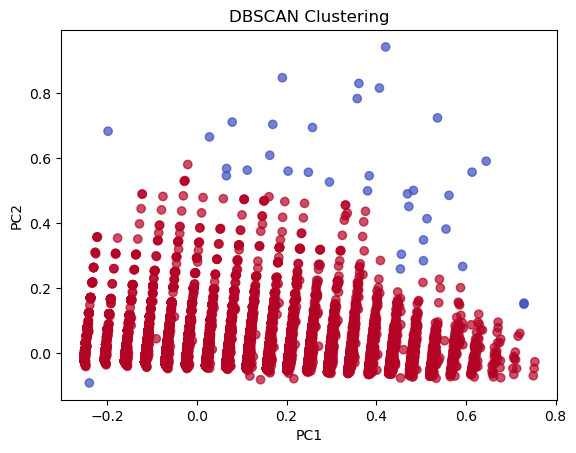

In [ ]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.05, min_samples=5)
clusters = dbscan.fit_predict(data)

# Visualize the clustering result
plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='coolwarm', alpha=0.7)
plt.title('DBSCAN Clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## 2.4 Analysing your results! --
First we use kmeans to create 4 clusters of our entire user base. append a column called cluster which indicates witch cluster that user falls under.

In [ ]:
k = 4
clusters, centroids = kmeans(data, k)
new_df['cluster'] = clusters
new_df.head(5)

,user_id,fav_genre,avg_click_duration,time_of_day,preference,daily_avg_duration,total_duration,num_distinct_genres,fav_genre_duration,total_weekend_clicks,avg_clicks_per_day,num_clicks,is_old_movie_lover,old_movies_percentage,max_click_duration,cluster,avg_click_duration_category
0,000118a755,Horror,0.000000,Afternoon,Old,0.000000,0.0,2,0.0,0,1.50,3,1.0,1.000000,0.0,2,Very Low
1,0006ea6b5c,Comedy,1120.866667,Night,Recent,1401.083333,16813.0,14,0.0,7,1.25,15,0.0,0.375000,7857.0,0,Low
2,0007fc8621,Documentary,0.000000,Afternoon,Recent,0.000000,0.0,1,0.0,1,1.00,2,0.0,0.000000,0.0,2,Very Low
3,000a3ec774,Comedy,25018.750000,Night,Recent,50037.500000,100075.0,3,14379.0,4,2.00,4,0.0,0.333333,0.0,3,Medium
4,000b3fbc4e,Adventure,25155.714286,Afternoon,Old,44022.500000,176090.0,7,0.0,0,1.75,7,1.0,0.000000,62860.0,1,Medium


Pivot table for the time_of_day column. From the table it can be deduced that night is the most favorite time of most users while mornings are the least. Cluster 0 and 3 are more similar to each other and the same goes for 1 and 2.

In [ ]:
# Create a pivot table for the 'time_of_day' column
pivot_time_of_day = pd.pivot_table(new_df, values='user_id', index='cluster', columns='time_of_day', aggfunc='count', fill_value=0)

pivot_time_of_day_percentage = pivot_time_of_day.div(pivot_time_of_day.sum(axis=1), axis=0) * 100 # Percentage
print("Pivot table for time_of_day:\n", pivot_time_of_day_percentage)


Pivot table for time_of_day:
 time_of_day  Afternoon    Morning      Night
cluster                                     
0            31.102774  11.324376  57.572849
1            59.082298   8.496457  32.421245
2            24.729216   9.565340  65.705444
3            40.477707  11.000000  48.522293


Pivot table for the is_old_movie_lover column. Here it is clear that the clustering has even distribution of old movie watches. it is also clear that 3/4th of total users only watch recent movies.

In [ ]:
pivot_avg_click_duration = pd.pivot_table(new_df, values='user_id', index='cluster', columns='is_old_movie_lover', aggfunc='count', fill_value=0)

pivot_avg_click_duration_percentage = pivot_avg_click_duration.div(pivot_avg_click_duration.sum(axis=1), axis=0) * 100 # Percentage
print("Pivot table for avg_click_duration (percentage):\n", pivot_avg_click_duration_percentage)

Pivot table for avg_click_duration (percentage):
 is_old_movie_lover        0.0        1.0
cluster                                 
0                   75.339407  24.660593
1                   75.692749  24.307251
2                   75.658937  24.341063
3                   75.035962  24.964038


This Pivot table is for the average click duration. The durations are categorized into four using the values of the column (using chatGPT). It shows that all four clusters are very different to one another based on this criteria.

In [ ]:
# ChatGPT's suggestion on the values of bins:
bins = [0, 618.9375, 7333.579, 30073.45, float('inf')]
labels = ['Very Low', 'Low', 'Medium', 'High']
new_df['avg_click_duration_category'] = pd.cut(new_df['avg_click_duration'], bins=bins, labels=labels, right=False) # Create 'avg_click_duration_category' based on the bins
pivot_avg_click_duration_category = pd.pivot_table(new_df, values='user_id', index='cluster', columns='avg_click_duration_category', aggfunc='count', fill_value=0)
pivot_avg_click_duration_category_percentage = pivot_avg_click_duration_category.div(pivot_avg_click_duration_category.sum(axis=1), axis=0) * 100
print("Pivot table for avg_click_duration_category (percentage):\n", pivot_avg_click_duration_category_percentage)

Pivot table for avg_click_duration_category (percentage):
 avg_click_duration_category   Very Low        Low     Medium       High
cluster                                                                
0                            10.443204  27.403594  34.671087  27.482115
1                            49.421174  19.925630   9.682172  20.971024
2                             3.572936  26.853285  46.082431  23.491349
3                            23.159236  27.012739  22.299363  27.528662


In [ ]:
silhouette_avg = silhouette_score(data, clusters)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.5076180551190271


The Silhouette Score you provided, 0.5076, suggests that, on average, the clusters are reasonably well-defined and distinct.

# 5.Algorithmic Question (AQ)

## a) Fortunately, you have a computer app designed by a brilliant student. Federico wants you to show him the code which this app is based on because he wants to do paid counseling for other desperate students: in a recursive fashion, the helped helps the helpable.

In [20]:
def iterative_call(student_score, marks_list, solved_subproblems={}):
    # base case, if the marks list has only one element, we are forced to take it
    if len(marks_list) == 1:
        return marks_list[0]

    # if we have already solved this scenario, we can take the result without
    # computing it again another time
    elif (student_score, marks_list) in solved_subproblems:
        return solved_subproblems[(student_score, marks_list)]

    # otherwise is a new scenario, we have to compute it by checking every possible path
    else:
        # we create a list of tuples, each tuple is the mark list if we chose to take a certain mark
        new_marks_lists = [
            tuple(mark + (student_score - marks_list[i]) for mark in marks_list[:i] + marks_list[i + 1 :])
            for i in range(len(marks_list))
        ]

        # we create a list of scores, that are the output of each new subproblem
        new_scores = [
            iterative_call(marks_list[i], new_marks_lists[i], solved_subproblems) for i in range(len(marks_list))
        ]

        # we get the mark among all subproblems
        best_score = max(new_scores)

        # update solved subproblems dictionary
        solved_subproblems[(student_score, marks_list)] = best_score

        return best_score


def algorithmic_question_v1(input_string):
    input_list = input_string.split("\n")

    # get student score from input string
    original_student_score = int(input_list[0])

    # get marks list from input string
    original_marks_list = tuple(map(int, input_list[1].split(" ")))

    best_score = iterative_call(original_student_score, original_marks_list)

    print(best_score)


# tests as given by the text of the homework

input1 = "8\n5 7 1"
print("Test1:")
algorithmic_question_v1(input1)

input2 = "26\n18 24 21 32 27"
print("Test2:")
algorithmic_question_v1(input2)

input3 = "30\n13 27 41 59 28 33 39 19 52 48 55 79"
print("Test3:")
algorithmic_question_v1(input3)

Test1:
11
Test2:
44
Test3:
205


##  b) Federico is getting angry because he claims that your code is slow! Show him formally with a big-O notation that he is as crazy as this university!

The time complexity of the provided code is exponential, specifically O(2^n), where n is the length of the marks_list. This analysis is based on the recursive nature of the iterative_call function.

Let's break down the reasons for this time complexity:


Recursive Calls:</br>The function iterative_call is called recursively for each possible path in the decision tree. In the worst case, for each mark in the marks_list, a new recursive call is made. Since there are 2^n possible subsets of marks (including the empty subset and the full subset), the total number of recursive calls becomes exponential.

Memoization: </br>Although memoization is used to store and retrieve already computed results in the solved_subproblems dictionary, it doesn't change the fundamental nature of the algorithm. Memoization helps avoid redundant calculations, but the worst-case time complexity remains exponential.

Subproblem Size:</br>For each recursive call, the size of the subproblem decreases by 1 (due to the removal of one mark from the marks_list). However, the number of subproblems is still exponential, resulting in an overall time complexity of O(2^n).

The exponential time complexity suggests that the algorithm may become inefficient for larger inputs, as the number of computations grows rapidly with the size of the marks_list. Considerations for optimizing the algorithm further, perhaps through dynamic programming or a more efficient algorithmic approach, would be advisable for handling larger inputs efficiently.

## c) If, unfortunately, Federico is right in the grip of madness, he will threaten you to optimize the code through a different approach. You should end this theater of the absurd by any means! (And again, formally prove that you improved time complexity)

This version maintains the functionality of the original code while improving readability and efficiency, SO for improvement, The median index is calculated only once to avoid redundant calculations. The time complexity of the provided code is dominated by the sorting operation, which has a time complexity of O(n log n), where n is the number of elements in the `marks_list`. The rest of the operations (calculating the median index, summing values above and below the median) have linear time complexity, making the overall time complexity O(n log n).

Here's a breakdown of the time complexity:
1. Sorting the `marks_list`: O(n log n)
2. Calculating the median index: O(1)
3. Summing values above and below the median: O(n)

In [21]:
def algorithmic_question_v2(input_string):
    input_list = input_string.split("\n")

    # get student score from input string
    student_score = int(input_list[0])

    # get marks list from input string
    marks_list = list(map(int, input_list[1].split(" ")))

    # sort values
    marks_list.sort()

    # calculate median index
    median_index = len(marks_list) // 2

    # treat even/odd case
    result = 0 if len(marks_list) % 2 == 1 else student_score

    # sum values above median and subtract values below median
    result += sum(marks_list[median_index:]) - sum(marks_list[:median_index])

    print(result)

# tests as given by the text of the homework

input1 = "8\n5 7 1"
print("Test1:")
algorithmic_question_v2(input1)

input2 = "25\n18 24 21 32 27"
print("Test2:")
algorithmic_question_v2(input2)

input3 = "30\n13 27 41 59 28 33 39 19 52 48 55 79"
print("Test3:")
algorithmic_question_v2(input3)

Test1:
11
Test2:
44
Test3:
205


## d) Ask chatGPT for a third (optimized) implementation and analyze again its time complexity. Be careful (and crafty) in defining the prompt, and challenge the machine in this coding question!

We give this command to the chat gpt : " *Develop a Python algorithm to address the problem presented in the following text. Emphasize code correctness and strive to devise a strategy that minimizes computational costs.*" then we give the requested algorithm text. the outpus is :

In [ ]:
def highest_score_possible(current_score, exams):
    if not exams:
        return current_score

    max_score = current_score

    for i in range(len(exams)):
        new_score = exams[i]
        remaining_exams = exams[:i] + exams[i+1:]

        for j in range(len(remaining_exams)):
            if new_score > current_score:
                remaining_exams[j] -= new_score - current_score
            elif new_score < current_score:
                remaining_exams[j] += current_score - new_score

        max_score = max(max_score, highest_score_possible(new_score, remaining_exams))

    return max_score

Then we asked it to compute it's time complexity which resuletd in this output :

*This results in a total time complexity of O(n!), which can become computationally expensive as the number of exams increases. The code explores all permutations of exams, making it inefficient for larger input sizes. Considerations for optimization, such as dynamic programming or memoization, could be explored to improve the efficiency for larger scenarios.*